In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import *
from copy import copy, deepcopy
import matplotlib as mpl
import seaborn as sns

from models.geophysic_models.carbon_cycle_models import *
from models.geophysic_models.temperature_dynamic_model import *
from models.geophysic import *
from models.game_theory.benefit_function import *
from models.game import *
from plot_function import *

sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "figure.titlesize": 16})
plt.rcParams.update({'mathtext.default':  'regular' })
sns.axes_style( { 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.bottom': True,
 'xtick.top': True,
 'ytick.left': True,
 'ytick.right': True})
# mpl.rc('text', usetex=True)
mpl.rc('ytick'  , labelsize=15)
mpl.rc('xtick'  , labelsize=15)
mpl.rc('legend' , fontsize= 15)
mpl.rc('axes'   , labelsize=15,  titlesize=16) 
# plt.rcParams['font.size'] = '16'

In [2]:
def best_response_dynamic_one_shot(array_actions : np.ndarray, list_players : list[player_class],
                                    exogeneous_emission : np.ndarray = E_EX, exogeneous_radiative_forcing : np.ndarray = F_EX,
                                    step_criterion : int = 100, utility_criterion : float = 0.0001,
                                    diplay_progress : bool = False):
    #Const

    loss = 1000
    k = 0
    inital_action = deepcopy(array_actions)
    list_of_all_action = [inital_action]
    n = len(list_players)

    while (loss > utility_criterion) and (k < step_criterion):
        list_action = deepcopy(list_of_all_action[-1])
        if diplay_progress:
            print('k:', k)
            print('loss:', loss)
            print('list_of_all_action',     list_of_all_action)
        for indice in range(n):
            # print('BRD player ',indice)
            sum_other_actions = np.sum(list_action) - list_action[indice]

            list_action[indice] = round(list_players[indice].best_response_one_shot(sum_other_actions, exogeneous_emission, exogeneous_radiative_forcing), 2)

        k +=1
        loss = sum( [(list_action[indice] - list_of_all_action[-1][indice])**2 for indice in range(n)])
        
        list_of_all_action.append(list_action)

    if diplay_progress:
        if step_criterion <= k :
            print("Reach the step criterion.")
        if loss <= utility_criterion :
            print("Reach the utlity criterion in {} steps.".format(k))
    return list_of_all_action[-1]

In [3]:
def repeated_one_shot_game(list_players : list[player_class],
                            carbon_model : Linear_Carbon_Model, temperature_model : Linear_Temperature_Dynamic,
                            array_exogeneous_emission : np.ndarray, array_exogeneous_radiative_forcing : np.ndarray):
    smc_game = geophysics(carbon_model, temperature_model)
    n = len(list_players)
    list_actions_intial = np.array([player.action_set[1]/n for player in list_players])
    array_action = np.zeros((t+1, n)) 
    array_sum_action = np.zeros(t+1)
    list_temp = []
    list_temp_2 = []

    for time in range(t+1):
        array_action[time] = best_response_dynamic_one_shot(list_actions_intial, list_players, exogeneous_emission= array_exogeneous_emission[time], exogeneous_radiative_forcing=array_exogeneous_radiative_forcing[time])
        array_sum_action[time] = np.sum(array_action[time])
        for player in list_players:
            player.smc.initialize_carbon_model(deepcopy(smc_game.carbon_state))
            player.smc.initialize_temperature_dynamic(deepcopy(smc_game.temperature_state))
            # print(player.name)
            # print("before", player.smc.temperature_model.atmospheric_temperature(smc_game.temperature_state))
            player.update_smc(array_sum_action[time], array_exogeneous_emission[time], array_exogeneous_radiative_forcing[time])
            # print("after", player.smc.atmospheric_temp)
        smc_game.five_years_cycle_deep(array_sum_action[time], array_exogeneous_emission[time], array_exogeneous_radiative_forcing[time])

        list_temp.append(smc_game.atmospheric_temp)


    return array_action.T, array_sum_action, list_temp


def utility_function(action :np.ndarray, temperature :np.ndarray, benefit_function : callable, damage_function : callable, impact_factor_of_temperature : float) -> np.ndarray:
    utility_array = np.zeros_like(action)
    for t in range(len(utility_array)):
        utility_array[t] = benefit_function(action[t]) - impact_factor_of_temperature * damage_function(temperature[t])
    return utility_array

In [4]:
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)

N = 6
T = 37

action_sets = np.array([[0.0, 11.0],        # China  
                        [0.0, 7.0],         # USA
                        [0.0, 4.0],         # EU
                        [0.0, 3.0],         # India
                        [0.0, 2.0],         # Russia
                        [0.0, 5.0]])        # other Asia    

deltas = np.array([1.1847,
                    1.1941,
                    1.1248,
                    0.9074,
                    1.2866,
                    1.1847]) 

beta_0 = np.array([15.0,
                    18.0,
                    17.0,
                    2.6,
                    1.6,
                    26.0])

alpha =1.1 

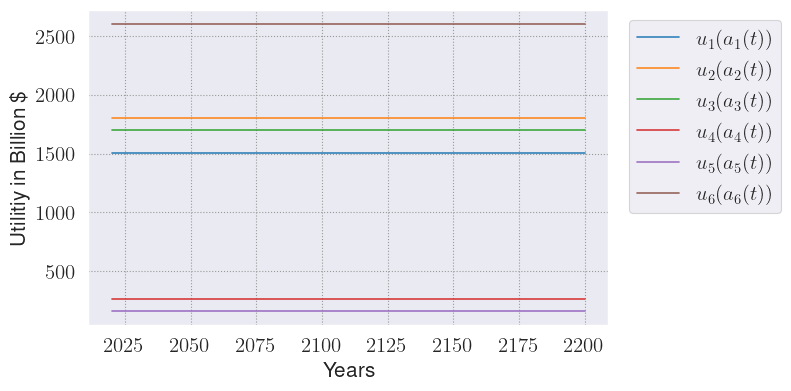

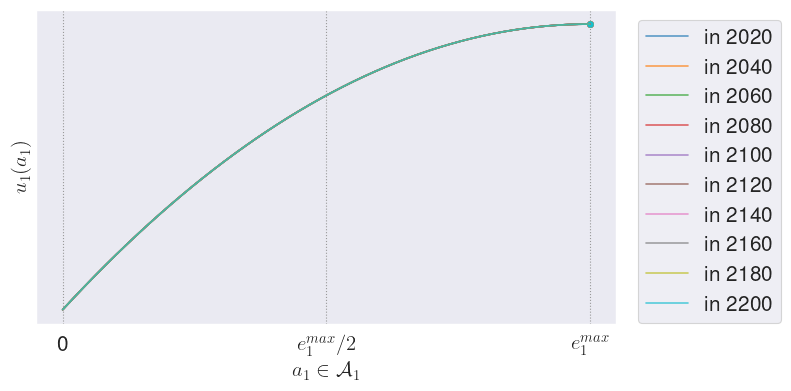

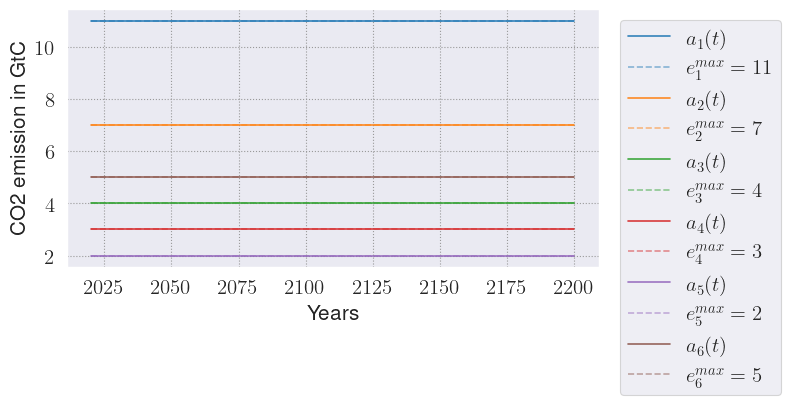

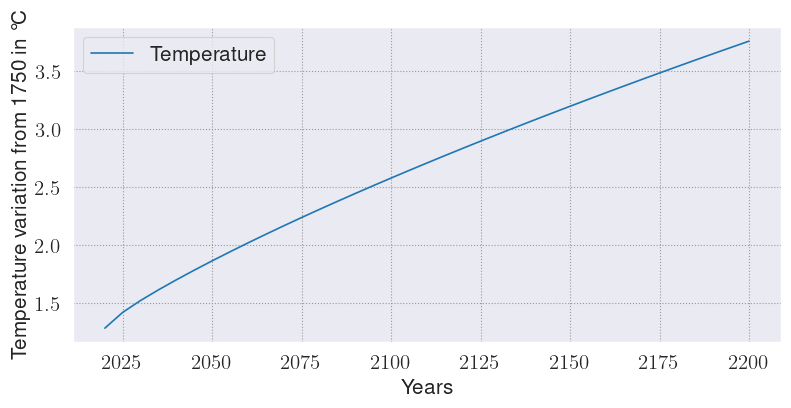

Shape of $u_1(a_1(t)) =$$-0.02 a_1(t)^2$$+$$ 0.50 a_1(t)$


In [5]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]

damage_coef = np.array([0,-5,5])*0 # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp_no_damage= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp_no_damage,  figsize=(8,4), name='no_damage_beamer')

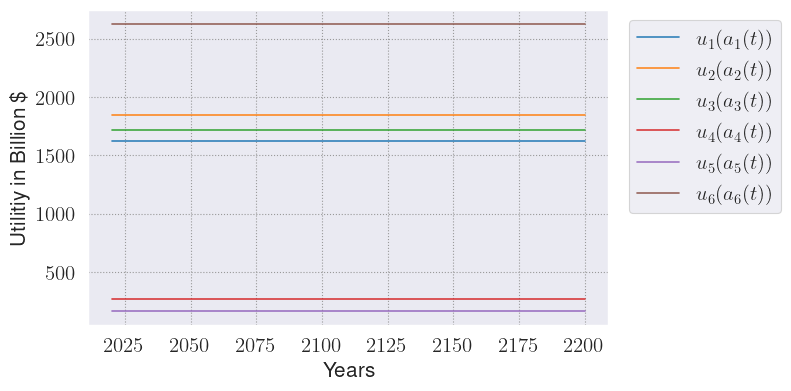

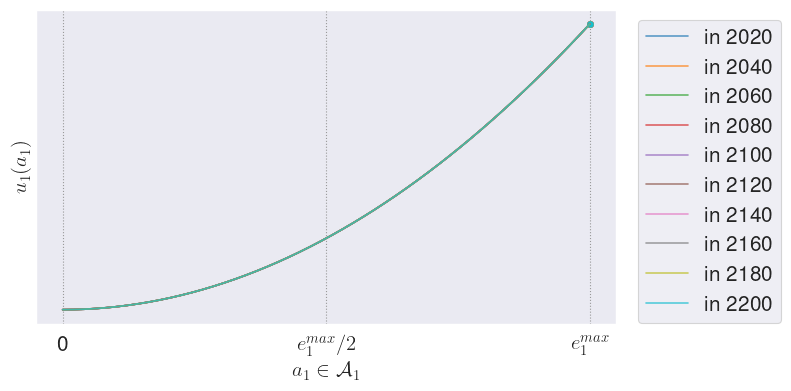

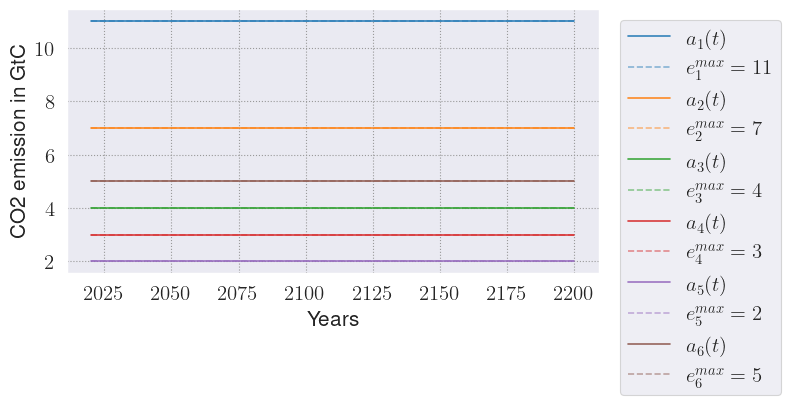

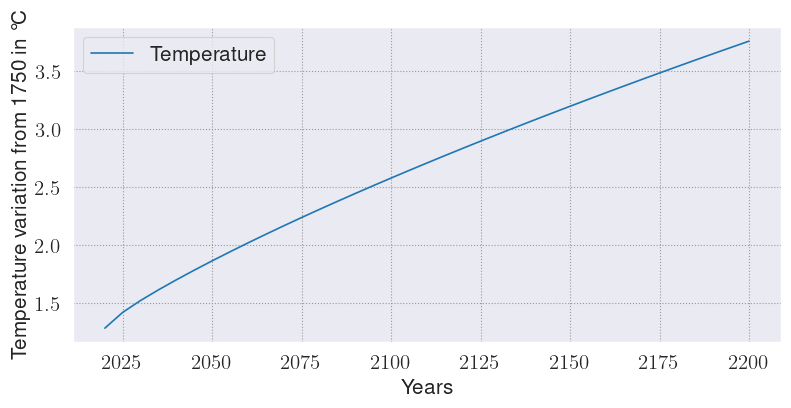

Shape of $u_1(a_1(t)) =$$1.00 a_1(t)^2$


In [11]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, 0 , 1]) for i in range(N)]

damage_coef = np.array([0,-5,5])*0 # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp_no_damage= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp_no_damage,  figsize=(8,4), name='no_damage_convex_beamer')

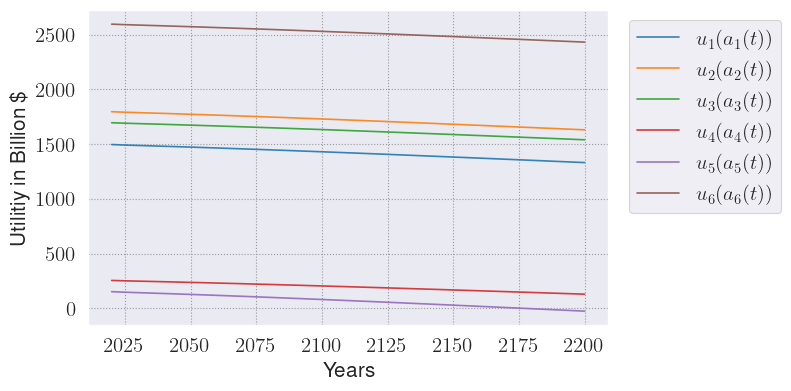

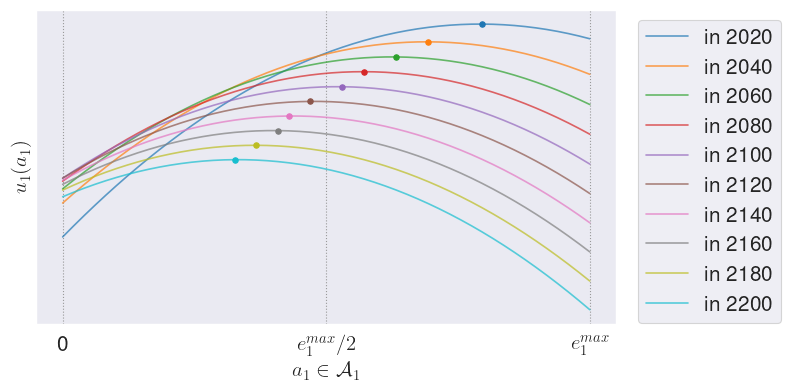

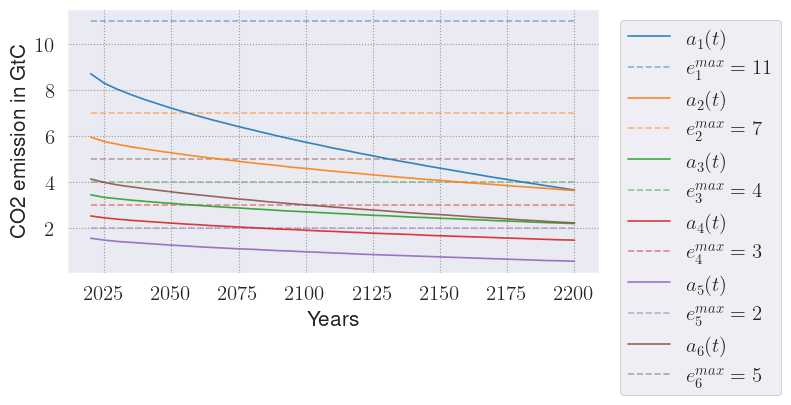

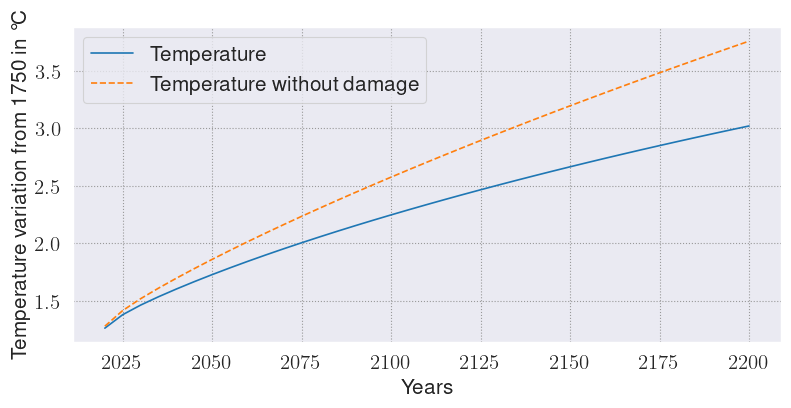

Shape of $u_1(a_1(t)) =$$-0.02 a_1(t)^2$$+$$ 0.50 a_1(t)$$ - (15.0y_{AT}^2 -15.0 y_{AT})(a(t)) $$^{1.1}$


In [12]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]

damage_coef = np.array([0,-15,15]) # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp,  figsize=(8,4), name='concave_plus_beamer',temp_no_damage = list_temp_no_damage)



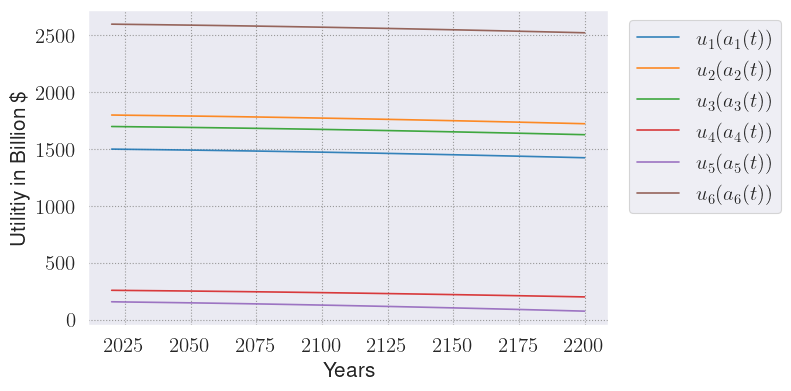

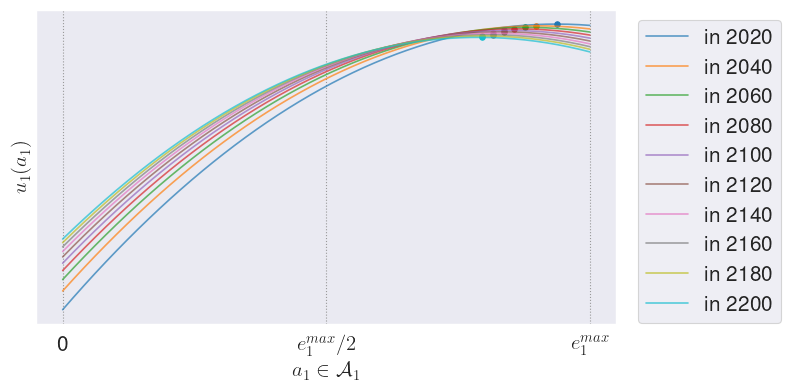

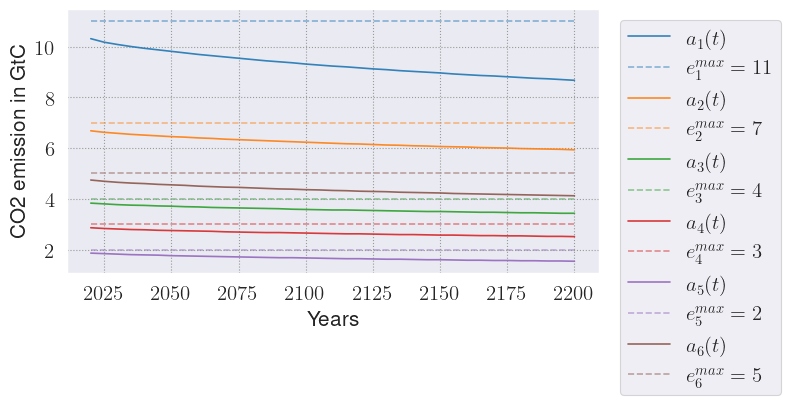

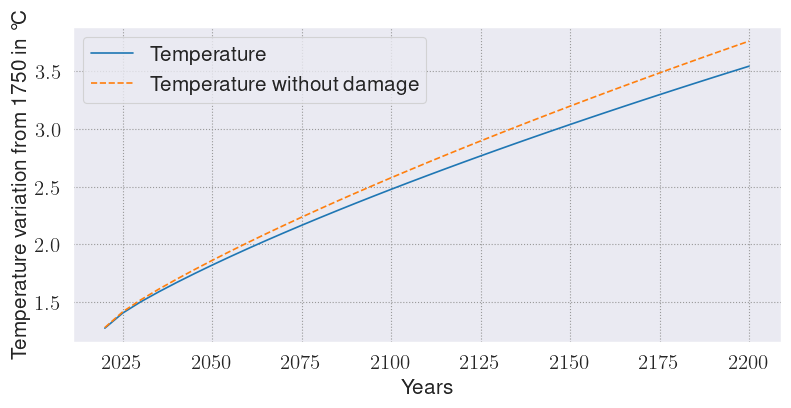

Shape of $u_1(a_1(t)) =$$-0.02 a_1(t)^2$$+$$ 0.50 a_1(t)$$ - (5.0y_{AT}^2 -5.0 y_{AT})(a(t)) $$^{1.1}$


In [13]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]

damage_coef = np.array([0,-5,5]) # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp,  figsize=(8,4), name='concave_beamer',temp_no_damage = list_temp_no_damage)



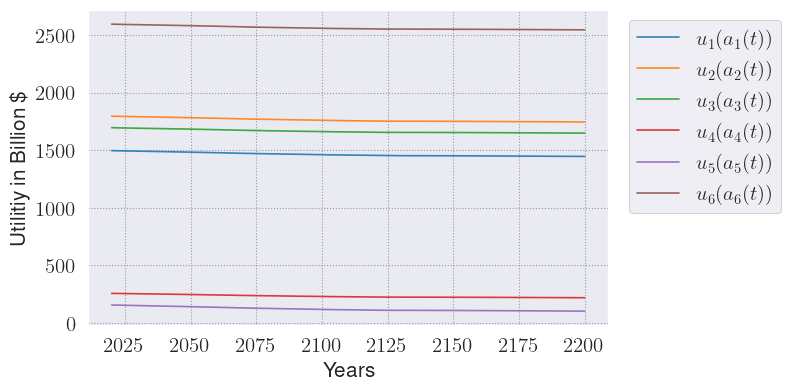

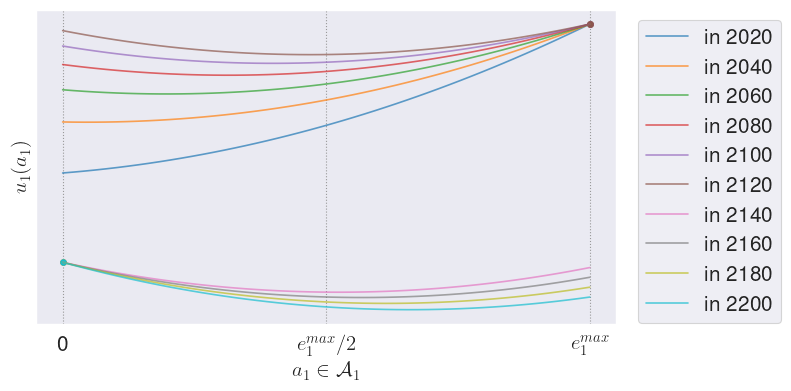

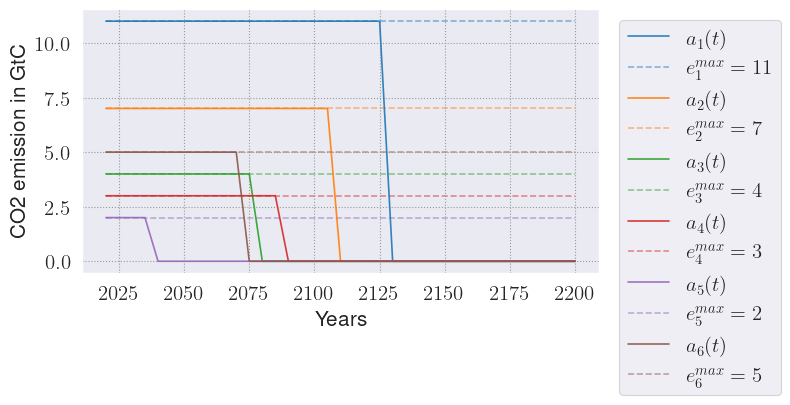

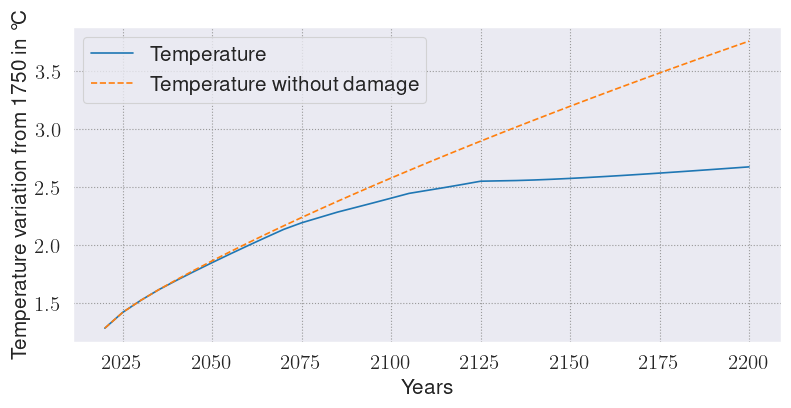

Shape of $u_1(a_1(t)) =$$0.01 a_1(t)^2$$+$$ 0.07 a_1(t)$$ - (7.0y_{AT}^2 -7.0 y_{AT})(a(t)) $$^{1.1}$


In [9]:
alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/1000 
list_benef_coef = [np.array([beta_0[i]*100,0.065 , alea_1[i]]) for i in range(N)]

damage_coef = np.array([0,-7,7]) # shift


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp, figsize=(8,4), name='convex_test_beamer',temp_no_damage = list_temp_no_damage)


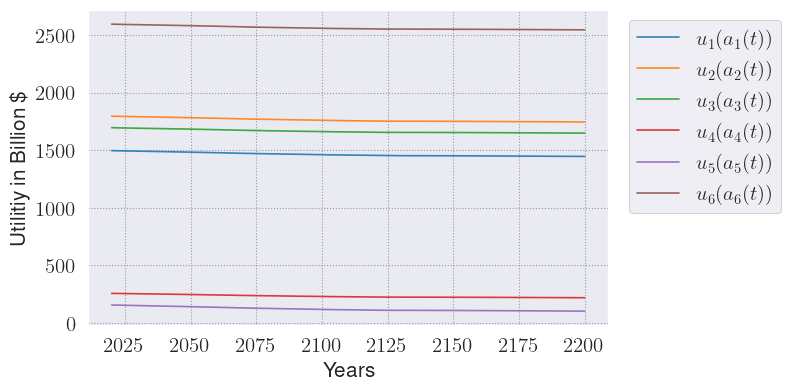

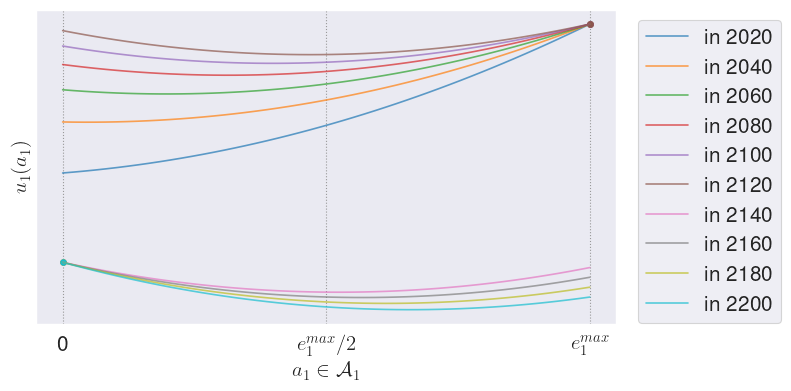

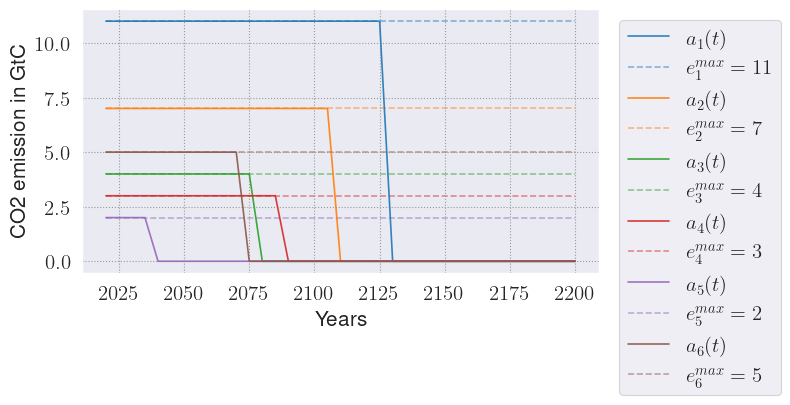

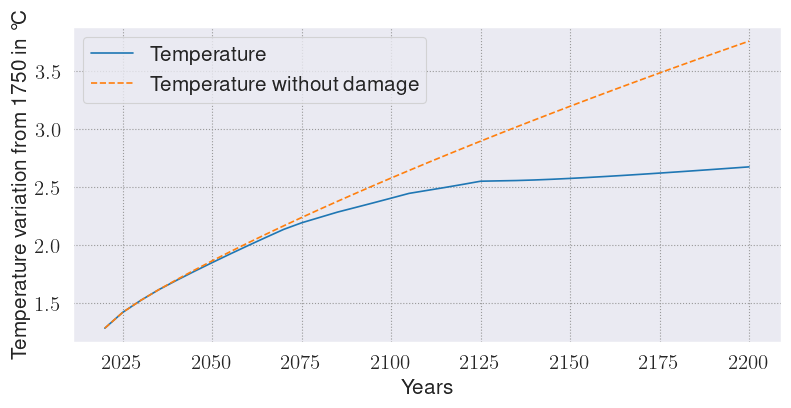

Shape of $u_1(a_1(t)) =$$0.01 a_1(t)^2$$+$$ 0.07 a_1(t)$$ - (7.0y_{AT}^2 -7.0 y_{AT})(a(t)) $$^{1.1}$


In [10]:
alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/1000 
list_benef_coef = [np.array([beta_0[i]*100,0.065 , alea_1[i]]) for i in range(N)]

damage_coef = np.array([0,-7,7]) # shift


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp, figsize=(8,4), name='convex_beamer',temp_no_damage = list_temp_no_damage)


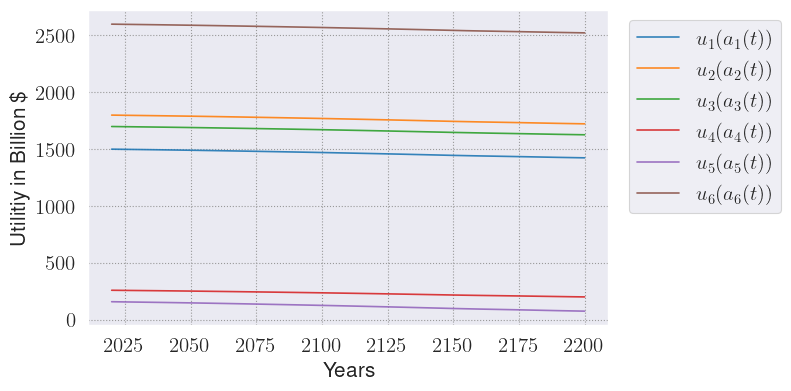

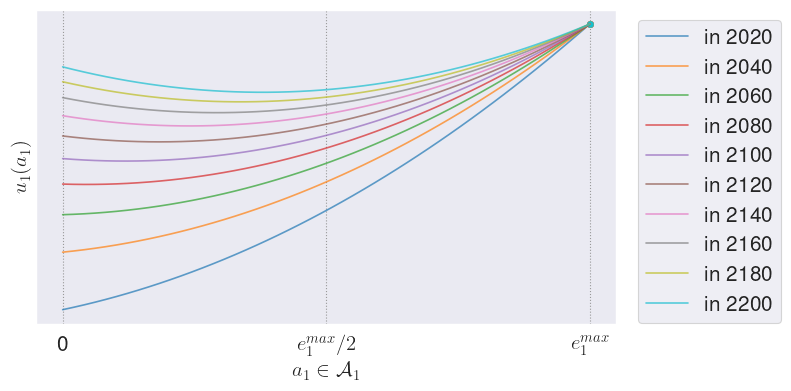

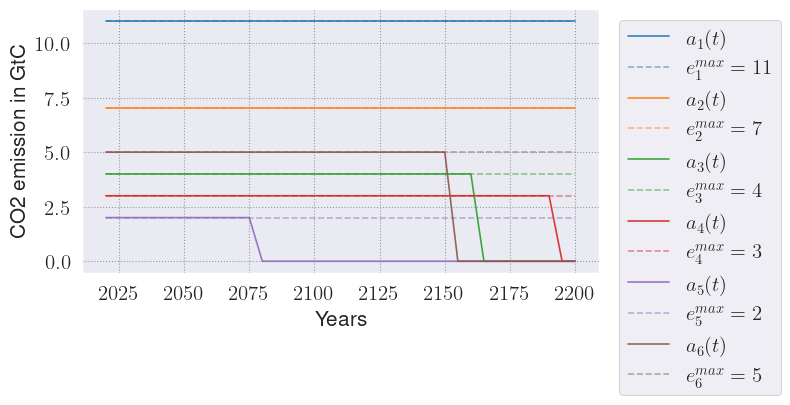

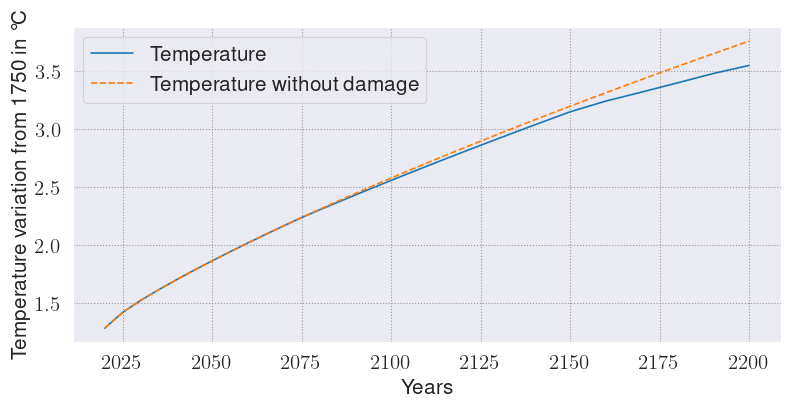

Shape of $u_1(a_1(t)) =$$0.01 a_1(t)^2$$+$$ 0.07 a_1(t)$$ - (5.0y_{AT}^2 -5.0 y_{AT})(a(t)) $$^{1.1}$


In [11]:
alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/1000 
list_benef_coef = [np.array([beta_0[i]*100,0.065 , alea_1[i]]) for i in range(N)]

damage_coef = np.array([0,-5,5]) # shift


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp, figsize=(8,4), name='convex_low_damage_beamer',temp_no_damage = list_temp_no_damage)

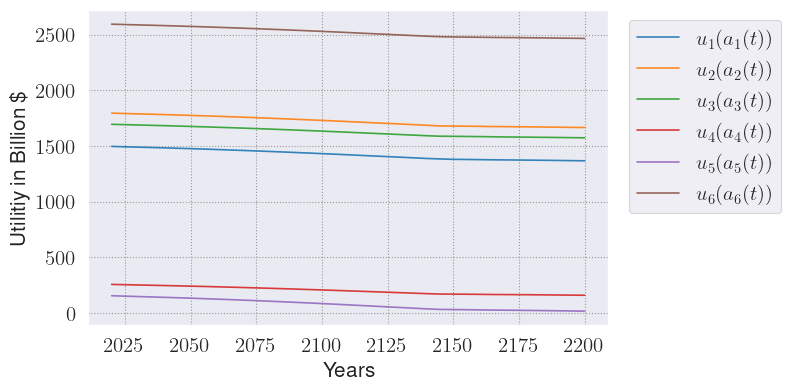

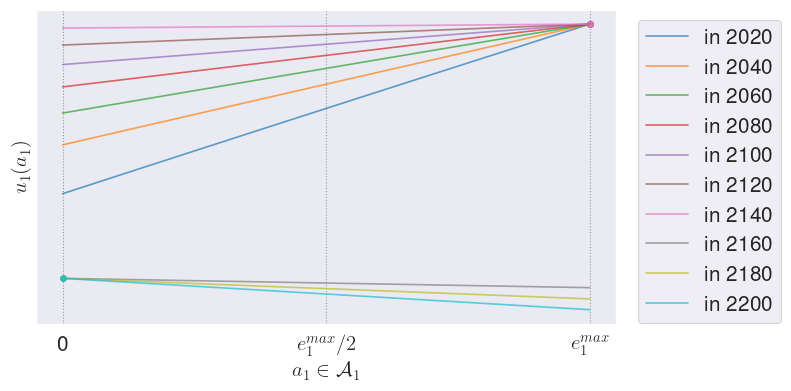

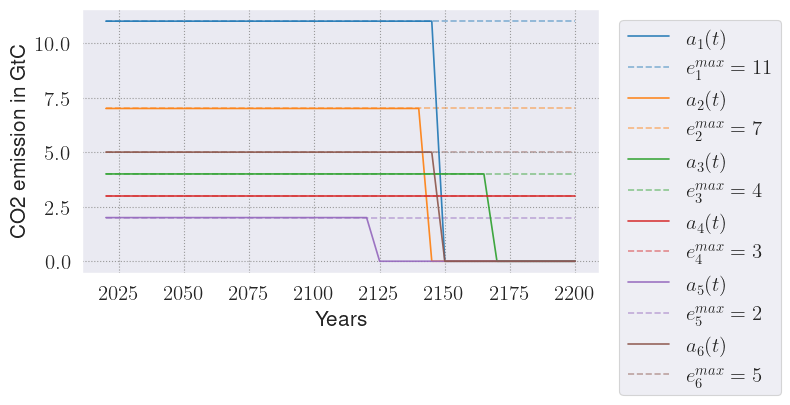

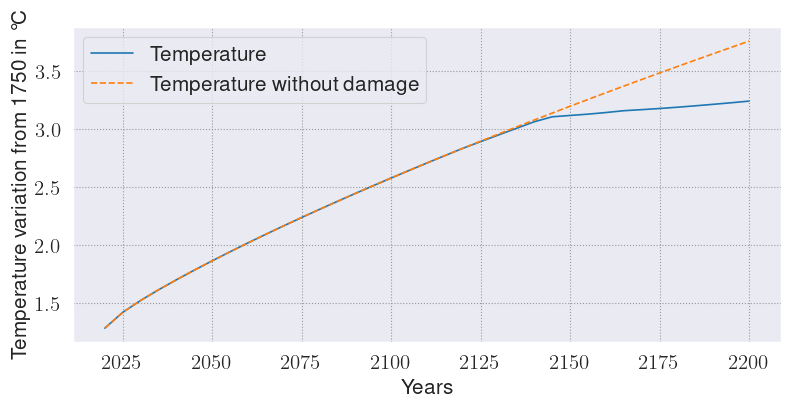

Shape of $u_1(a_1(t)) =$$ 0.20 a_1(t)$$ - (10.0y_{AT}^2 -10.0 y_{AT})(a(t)) $$^{1.1}$


In [12]:
alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/1000 
list_benef_coef = [np.array([beta_0[i]*100,.2 ,0]) for i in range(N)]

damage_coef = np.array([0,-10,10]) # shift


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, E_EX, F_EX)


plot_game(list_players, array_action, array_sum_action, list_temp, figsize=(8,4), name='affine_beamer',temp_no_damage = list_temp_no_damage)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import *
from copy import copy, deepcopy
import matplotlib as mpl
import seaborn as sns

from models.geophysic_models.carbon_cycle_models import *
from models.geophysic_models.temperature_dynamic_model import *
from models.geophysic import *
from models.game_theory.benefit_function import *
from models.game_theory.damage_function import *

from models.game import *
from plot_function import *

sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "figure.titlesize": 16})
plt.rcParams.update({'mathtext.default':  'regular' })
sns.axes_style( { 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.bottom': True,
 'xtick.top': True,
 'ytick.left': True,
 'ytick.right': True})
# mpl.rc('text', usetex=True)
mpl.rc('ytick'  , labelsize=15)
mpl.rc('xtick'  , labelsize=15)
mpl.rc('legend' , fontsize= 15)
mpl.rc('axes'   , labelsize=15,  titlesize=16) 
# plt.rcParams['font.size'] = '16'

carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)

N = 6

action_sets = np.array([[0.0, 11.0],        # China  
                        [0.0, 7.0],         # USA
                        [0.0, 4.0],         # EU
                        [0.0, 3.0],         # India
                        [0.0, 6.0],         # Russia
                        [0.0, 5.0]])        # other Asia    

deltas = np.array([1.1847,
                    1.1941,
                    1.1248,
                    0.9074,
                    1.2866,
                    1.1847]) 

gdp_max = np.array([15.0,
                    18.0,
                    17.0,
                    2.6,
                    1.6,
                    26.0])


alpha =1.1 


[11.  7.  4.  3.  6.  5.]
0.0
0
0
0
0
0
0
-3.207933213166987
1e-08
0
0
0
0
0
0
-3.2079332135673186
1e-08
0
0
0
0
0
0
-3.2079332135673186
1e-08
0
0
0
0
0
0
-3.2079332135673186
1e-08
0
0
0
0
0
0
-3.2079332135673186
1e-08
0
0
0
0
0
0
-3.2079332135673186
1e-08
0
0
0
0
0
0
-3.2079332135673186
[0. 0. 0. 0. 0. 0.]
[11.  7.  4.  3.  6.  5.]
0.0
1
1
1
1
1
1
-3.748634816220383
1e-08
1
1
1
1
1
1
-3.7486348166497456
1e-08
1
1
1
1
1
1
-3.7486348166497456
1e-08
1
1
1
1
1
1
-3.7486348166497456
1e-08
1
1
1
1
1
1
-3.7486348166497456
1e-08
1
1
1
1
1
1
-3.7486348166497456
1e-08
1
1
1
1
1
1
-3.7486348166497456
[0. 0. 0. 0. 0. 0.]
[11.  7.  4.  3.  6.  5.]
0.0
2
2
2
2
2
2
-3.953561397396877
1e-08
2
2
2
2
2
2
-3.9535613978381385
1e-08
2
2
2
2
2
2
-3.9535613978381385
1e-08
2
2
2
2
2
2
-3.9535613978381385
1e-08
2
2
2
2
2
2
-3.9535613978381385
1e-08
2
2
2
2
2
2
-3.9535613978381385
1e-08
2
2
2
2
2
2
-3.9535613978381385
[0. 0. 0. 0. 0. 0.]
[11.  7.  4.  3.  6.  5.]
0.0
3
3
3
3
3
3
-4.096272568013907
1e-08
3
3
3


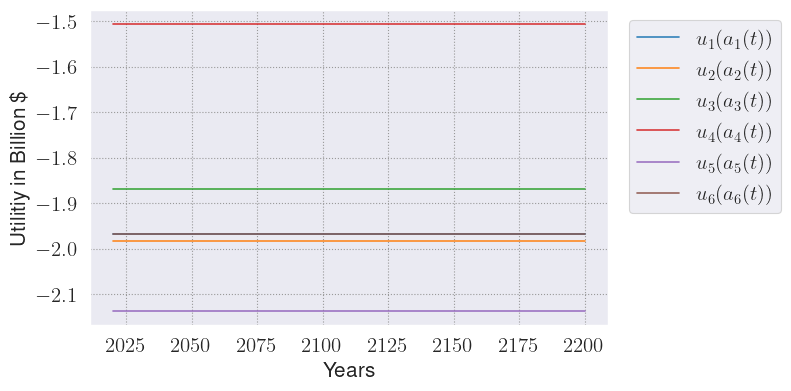

utilities


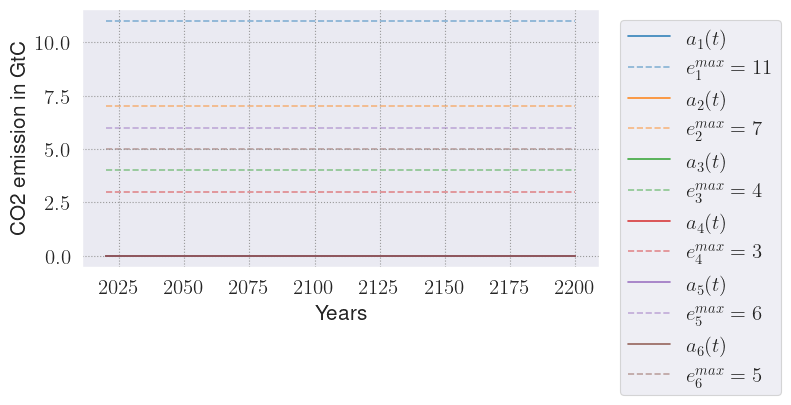

action profile
plot_so
plot_BAU


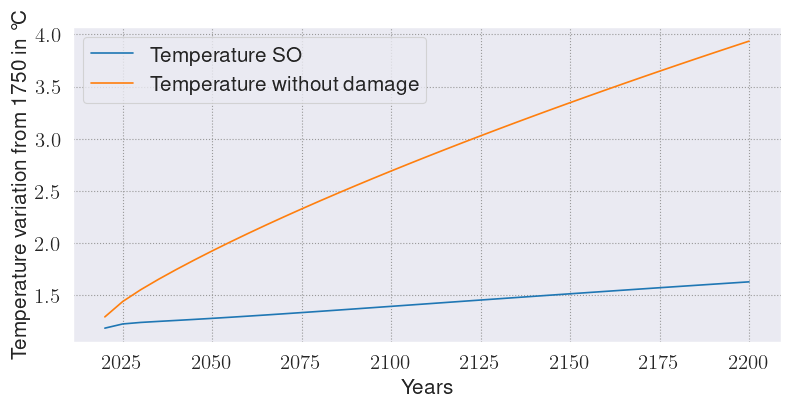

In [3]:
import scipy.stats as stats


damage_coef = np.array([0,-1,1.2])

alpha = 1.1
 


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefice_sigm(gdp_max[i], action_sets[i][1]), damage_function = damage_polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)


plot_Game(game, plot_nash=False, plot_SO=True,  plot_bau = True ,figsize=(8,4), name='test_v2')

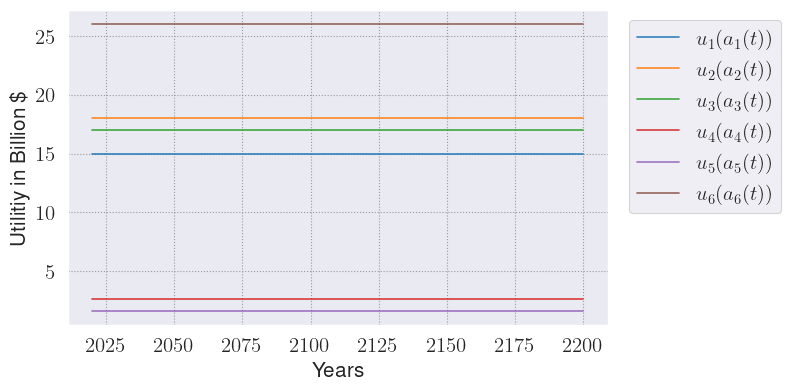

utilities


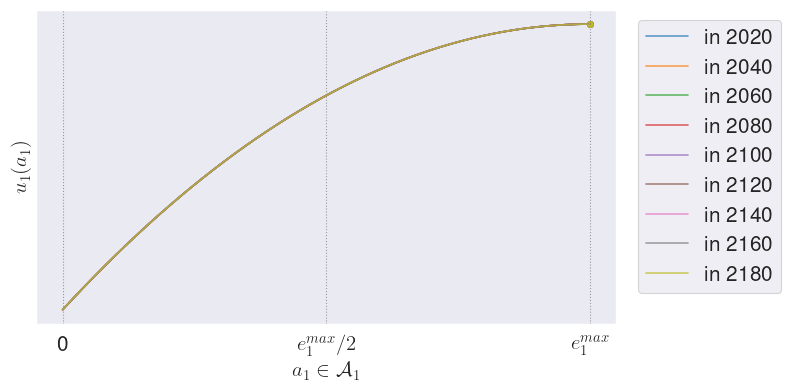

utility shape


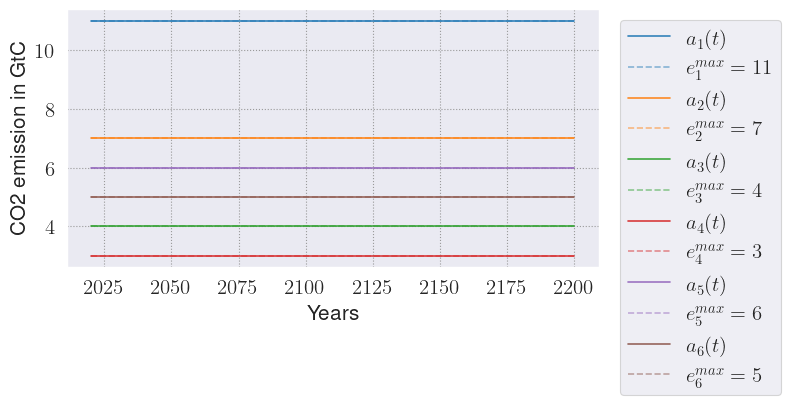

action profile
plot_nash


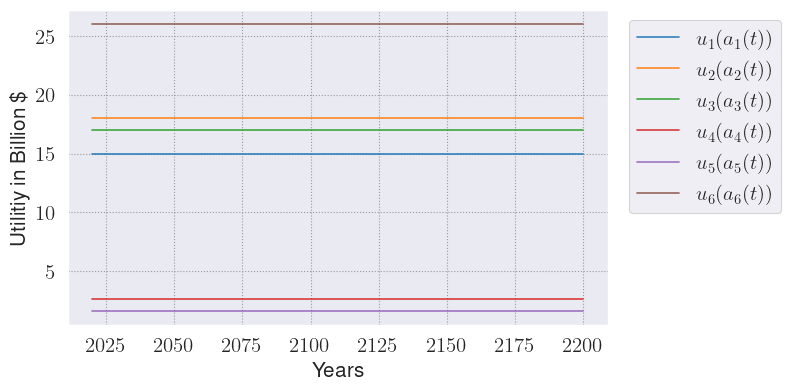

utilities


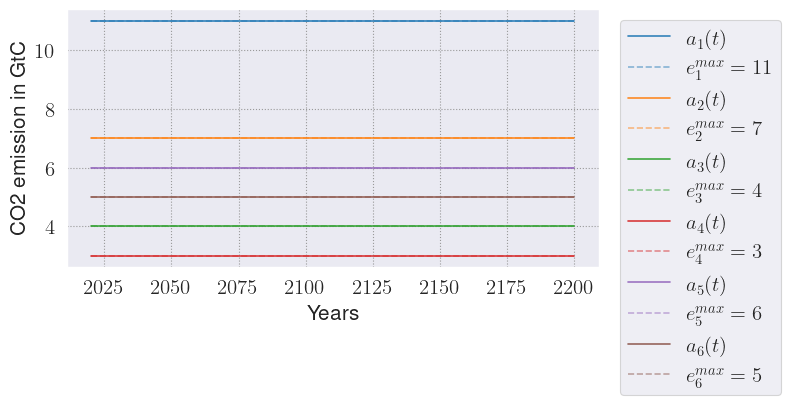

action profile
plot_so
plot_BAU


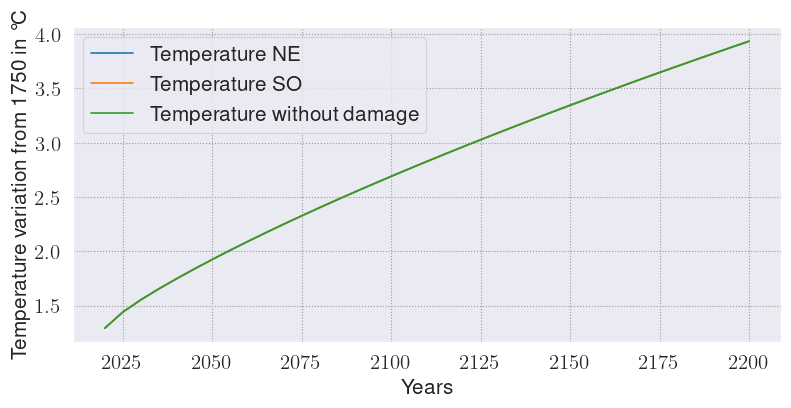

In [ ]:
import scipy.stats as stats


damage_coef = np.array([0,-1,10])*0

alpha = 1.2 


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.8), damage_function = damage_polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)


plot_Game(game, plot_nash=True, plot_SO=True,  plot_bau = True ,figsize=(8,4), name='test_v2')

In [14]:
game.so_action_profiles

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [7.62734066e-08, 7.62734066e-08, 7.62734066e-08, 7.62734066e-08,
        7.62734066e-08, 7.62734066e-08, 7.62734066e-08, 7.62734066e-08,
        7.62734066e-08, 7.62734066e-08, 7.62734066e-08, 7.62734066e-08,
        7.62734066e-08, 7.62734066e-08, 7.62734066e-08, 7.62734066e-08,
        7.62734066e-08, 7.62734066e-08,

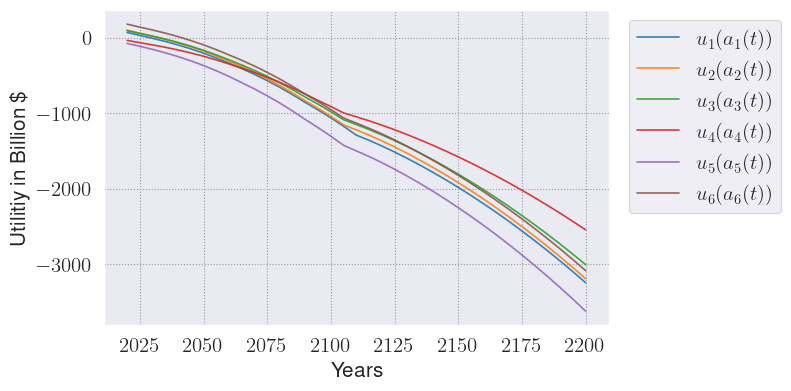

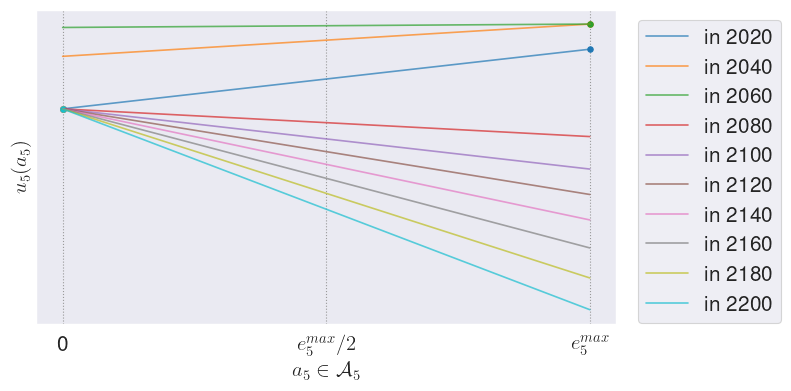

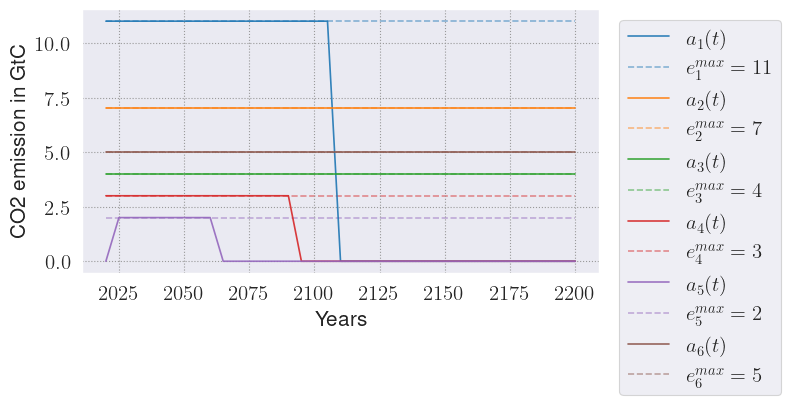

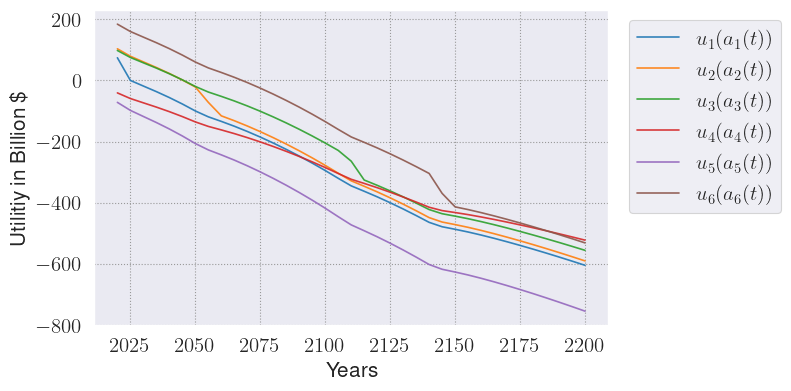

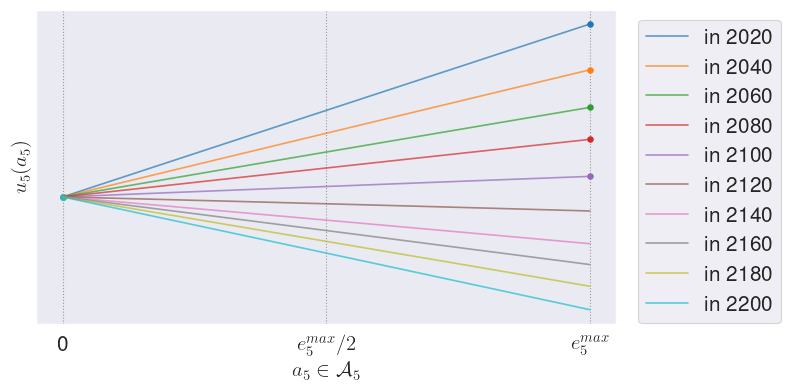

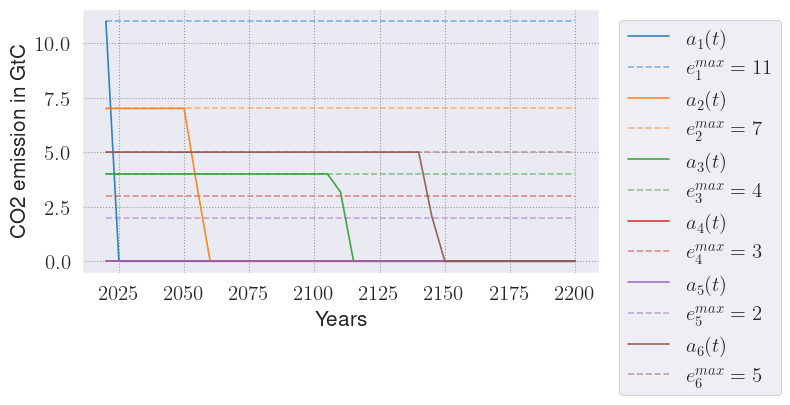

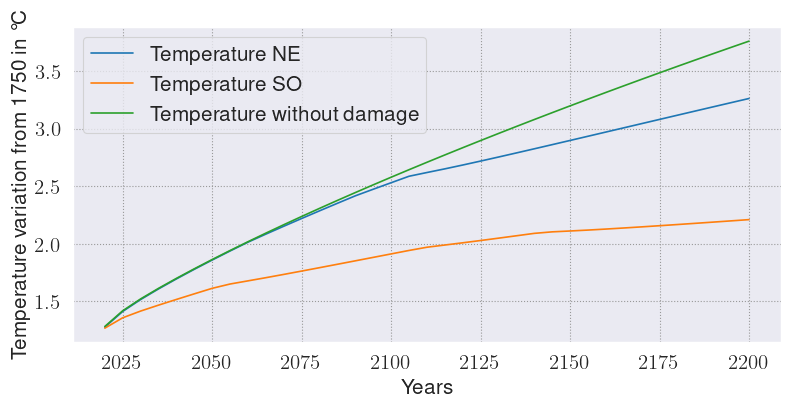

In [13]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*10*2/3, beta_0[i]*10/(3*action_sets[i][1]) ,0]) for i in range(N)]
damage_coef = np.array([0,0,5]) # shift

alpha = 2

list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)

game.repeated_s_o_one_shot_game()
array_action, array_sum_action, list_temp = game.so_action_profiles, game.so_sum_action_profiles, game.so_temp_profile
list_temp_no_damage = np.array(list_temp_no_damage)
plot_Game(game, plot_nash=True, plot_SO=True,  figsize=(8,4), name='test_so_affine',temp_no_damage=list_temp_no_damage, indice=4)

In [14]:
game.action_profiles

array([[11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  

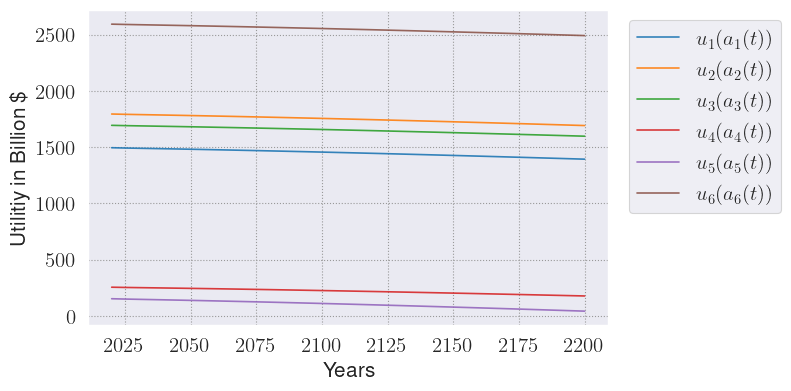

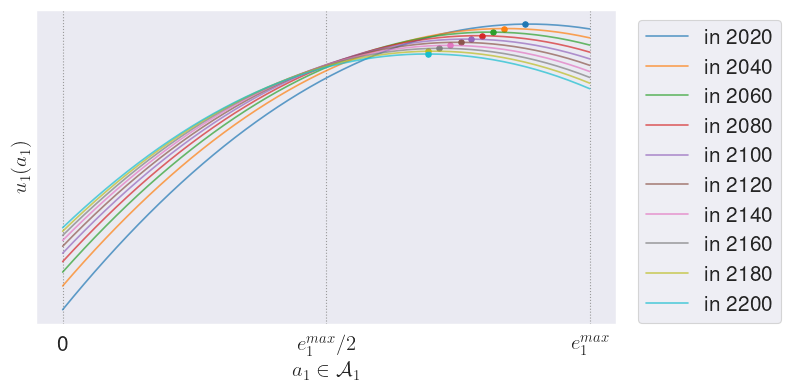

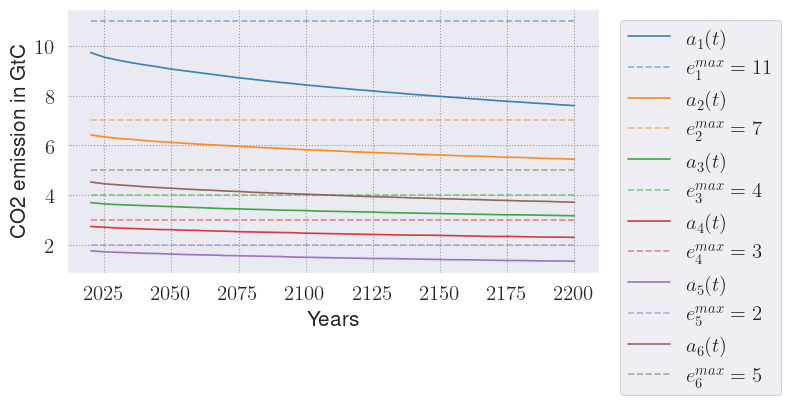

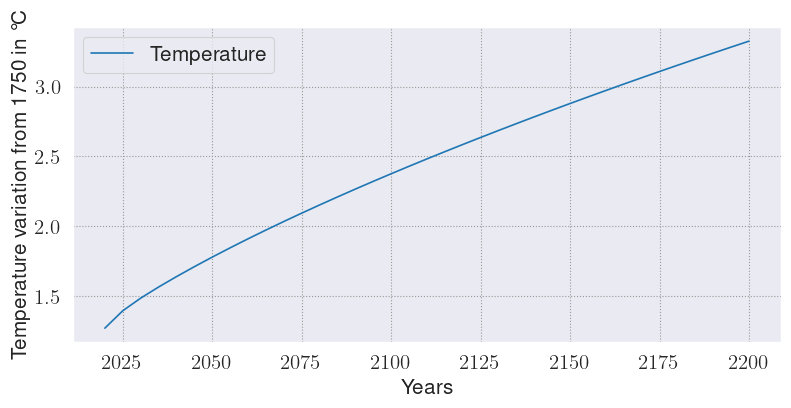

Shape of $u_1(a_1(t)) =$$-0.02 a_1(t)^2$$+$$ 0.50 a_1(t)$$ - (7.0y_{AT}^2 -5.0 y_{AT})(a(t)) $$^{1.1}$


In [2]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]

damage_coef = np.array([0,-5,7]) # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)

game.repeated_one_shot_game()
array_action, array_sum_action, list_temp_no_damage = game.action_profiles, game.sum_action_profiles, copy(game.temp_profile)

plot_game(list_players, array_action, array_sum_action, list_temp_no_damage,  figsize=(8,4), name='test')

In [4]:
list_temp_no_damage

array([1.27163703, 1.39591214, 1.4861788 , 1.56566269, 1.64007209,
       1.7112144 , 1.77977186, 1.84611211, 1.91056336, 1.97331955,
       2.03450775, 2.09430417, 2.15281964, 2.21019228, 2.26650048,
       2.32180861, 2.37615079, 2.42962254, 2.48229249, 2.53417548,
       2.58532436, 2.63579078, 2.68559985, 2.73477244, 2.7833069 ,
       2.83128332, 2.87867874, 2.92552459, 2.97183515, 3.01764198,
       3.06291619, 3.10770564, 3.15206117, 3.1959321 , 3.23934133,
       3.28231752, 3.32484908])

In [5]:
game.so_sum_utilities_profiles


array([8017.13351309, 8010.25114484, 8005.06306485, 8000.30816961,
       7995.65321477, 7991.02337783, 7986.40037788, 7981.78086233,
       7977.17018087, 7972.57070036, 7967.98900036, 7963.42823519,
       7958.89186733, 7954.38133939, 7949.90400954, 7945.45515295,
       7941.04336538, 7936.67288068, 7932.34577386, 7928.06675141,
       7923.83007428, 7919.64696218, 7915.51887055, 7911.44069077,
       7907.4253003 , 7903.47616756, 7899.58815817, 7895.76527183,
       7892.00612719, 7888.32249644, 7884.70622884, 7881.16183016,
       7877.69925125, 7874.31403774, 7870.99269129, 7867.76234898,
       7864.61211808])

In [6]:
game.so_action_profiles


array([[7.09956442, 6.46535418, 6.06704816, 5.74897805, 5.45432071,
        5.18341742, 4.93059621, 4.68966986, 4.46013765, 4.23772702,
        4.0253244 , 3.82038859, 3.62735668, 3.43426198, 3.25993343,
        3.07973501, 2.90574577, 2.73707683, 2.57199111, 2.41854063,
        2.26247256, 2.11093997, 1.97014266, 1.82104415, 1.67701847,
        1.54178599, 1.40985713, 1.28240375, 1.14742901, 1.02631105,
        0.90455298, 0.78051256, 0.66075097, 0.55543927, 0.43395759,
        0.32572831, 0.21130932],
       [5.22763942, 4.93807231, 4.75746588, 4.61258854, 4.47889058,
        4.35633793, 4.24105738, 4.13036199, 4.02694398, 3.92625164,
        3.82926264, 3.7376618 , 3.64802172, 3.56096873, 3.47971629,
        3.39881094, 3.32028526, 3.24431733, 3.16833729, 3.09930954,
        3.02766732, 2.95964911, 2.89469111, 2.82876646, 2.76304668,
        2.70087432, 2.64048795, 2.58119625, 2.52136295, 2.46602713,
        2.41060865, 2.35455144, 2.29849185, 2.24967467, 2.1954453 ,
        2.14737

In [7]:
type(list_temp_no_damage)

numpy.ndarray

In [6]:
def sigm(x, GDP_max, GDP_shift):
    return GDP_max /(1 + GDP_shift * np.exp(-x)) 

def benef_sigmoid(GDP_max, GDP_shift):
    def benef(x):
        return sigm(x, GDP_max, GDP_shift)
    return benef

In [25]:
x = np.linspace(0,11)

plt.plot(x,benef_sigmoid(x))

TypeError: benef_sigmoid() missing 1 required positional argument: 'GDP_shift'

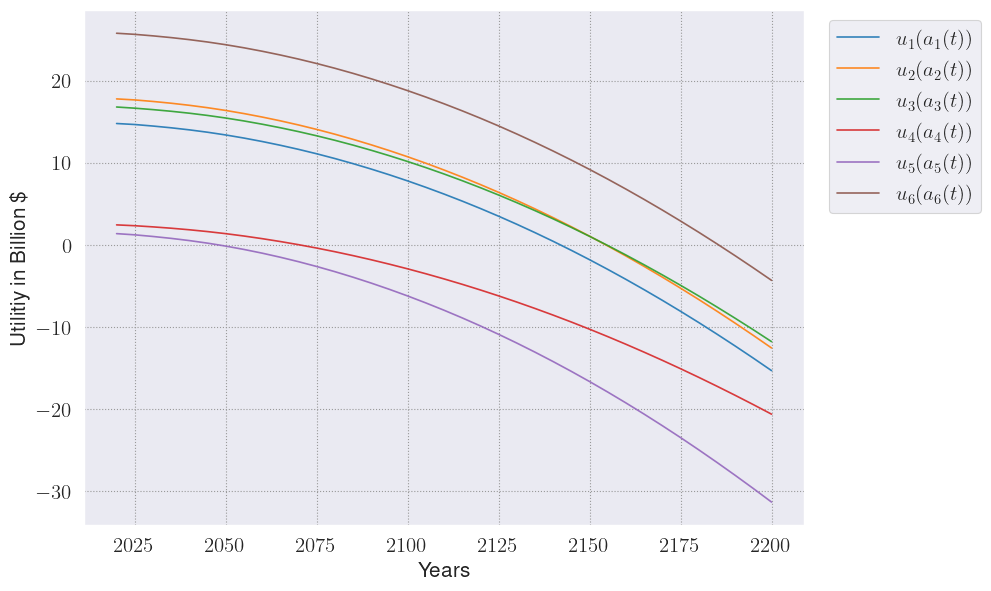

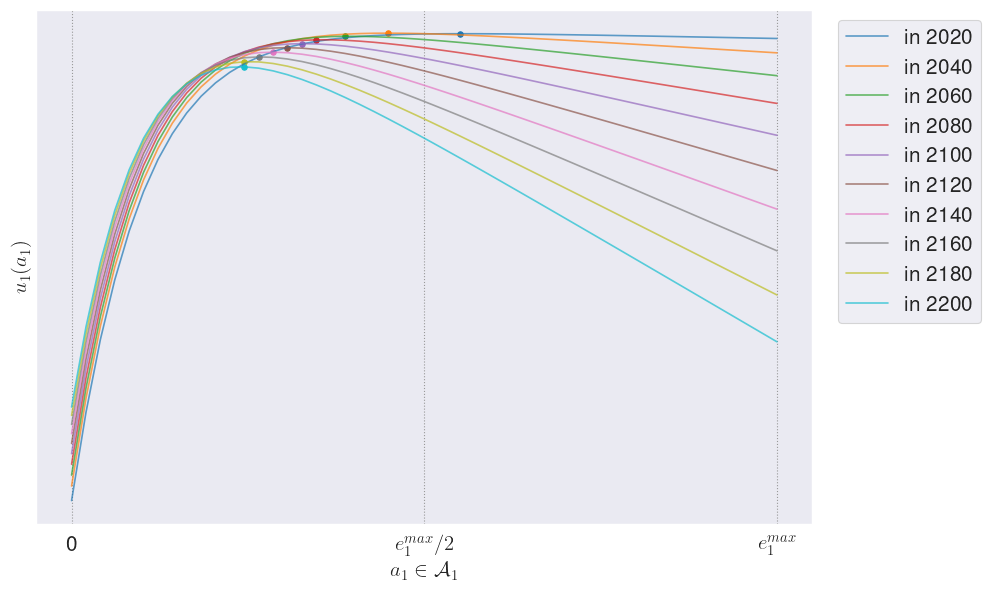

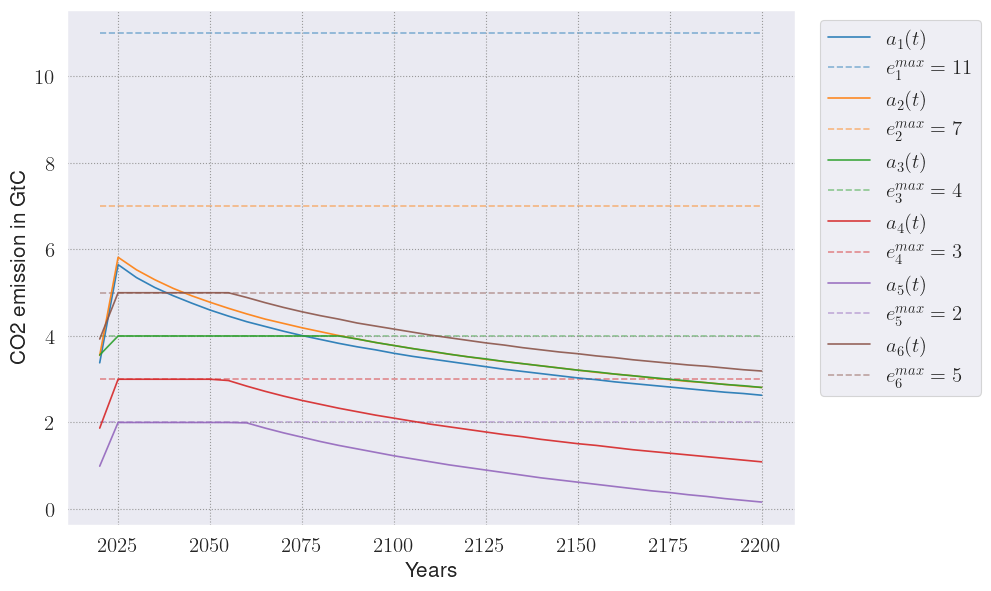

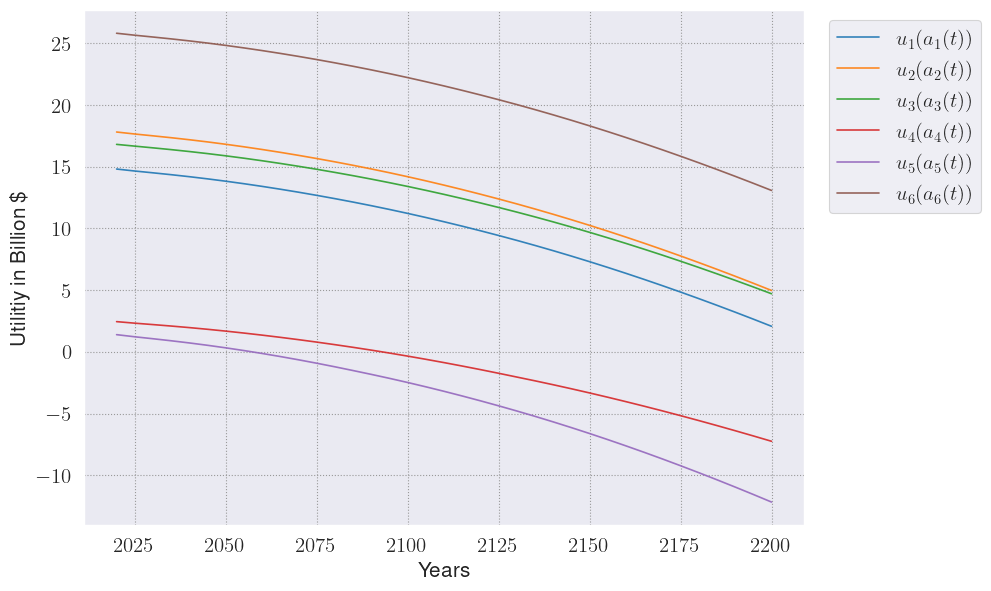

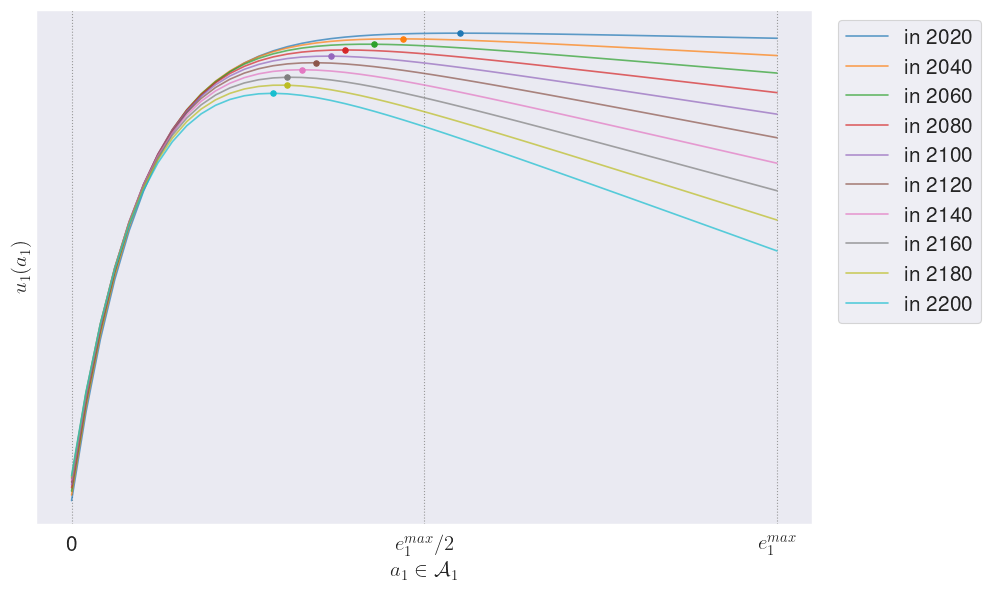

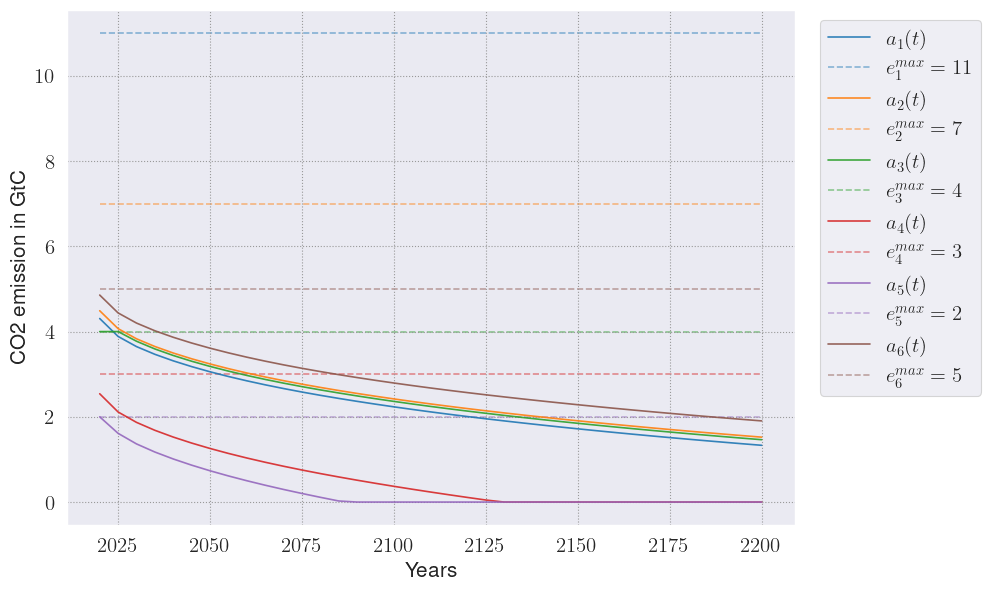

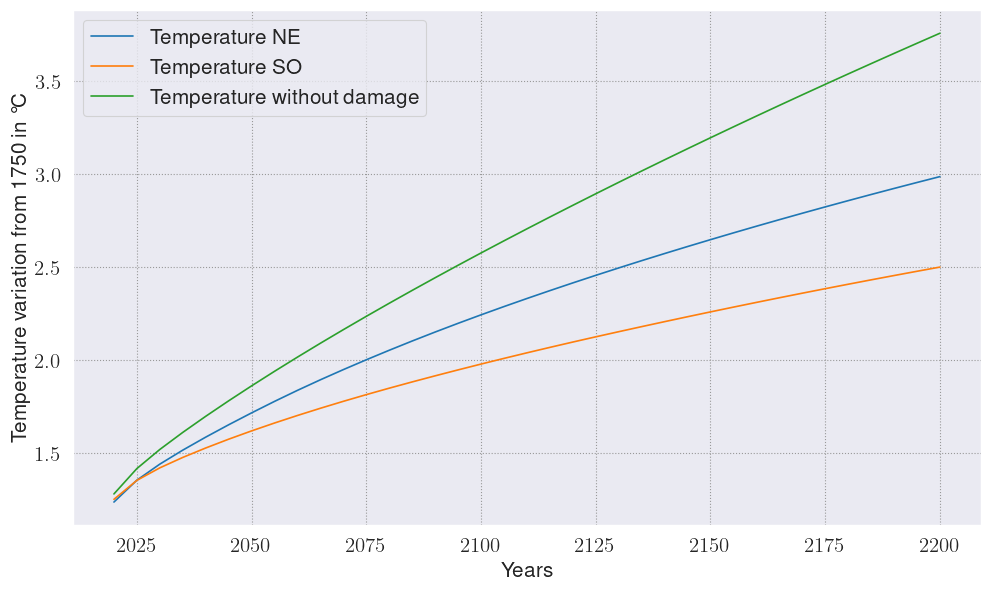

In [22]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([beta_0[i]*100, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]
damage_coef = np.array([0,-.7,.8]) # shift

alpha =2


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benef_sigmoid(GDP_max=beta_0[i], GDP_shift=.1), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)



game.repeated_s_o_one_shot_game()
array_action, array_sum_action, list_temp = game.so_action_profiles, game.so_sum_action_profiles, game.so_temp_profile
list_temp_no_damage = np.array(list_temp_no_damage)
plot_Game(game, plot_nash=True, plot_SO=True,  figsize=(10,6), name='test_sigm',temp_no_damage=list_temp_no_damage)

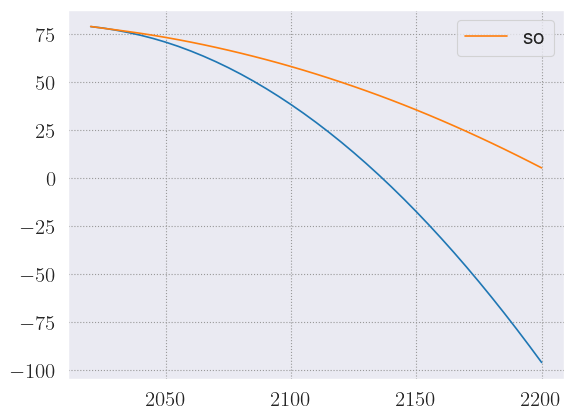

In [24]:


plt.plot(np.arange(2020, 2205, 5), game.sum_utilities_profiles)
plt.plot(np.arange(2020, 2205, 5), game.so_sum_utilities_profiles, label = 'so')
plt.legend()
plt.show()

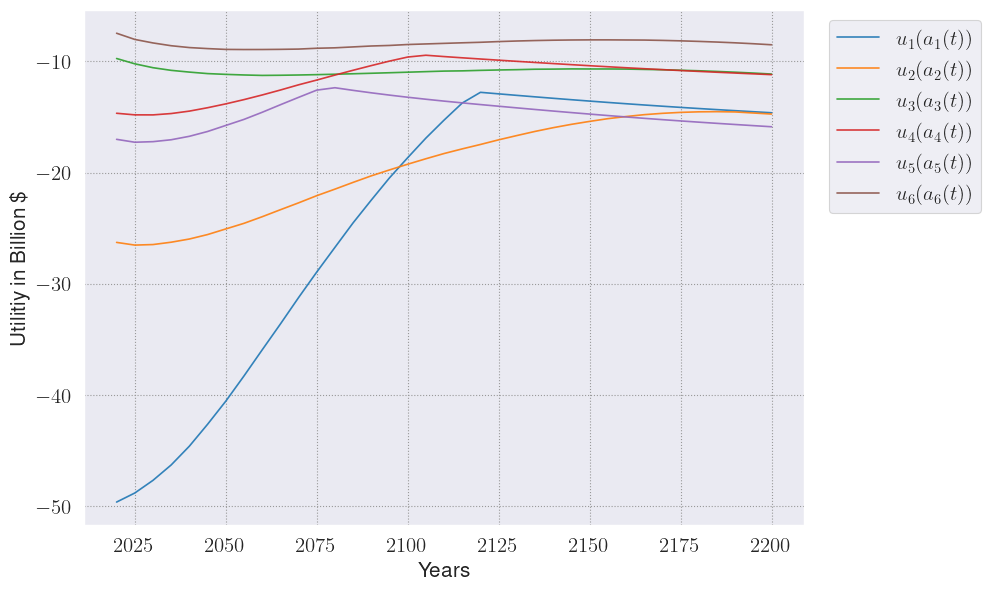

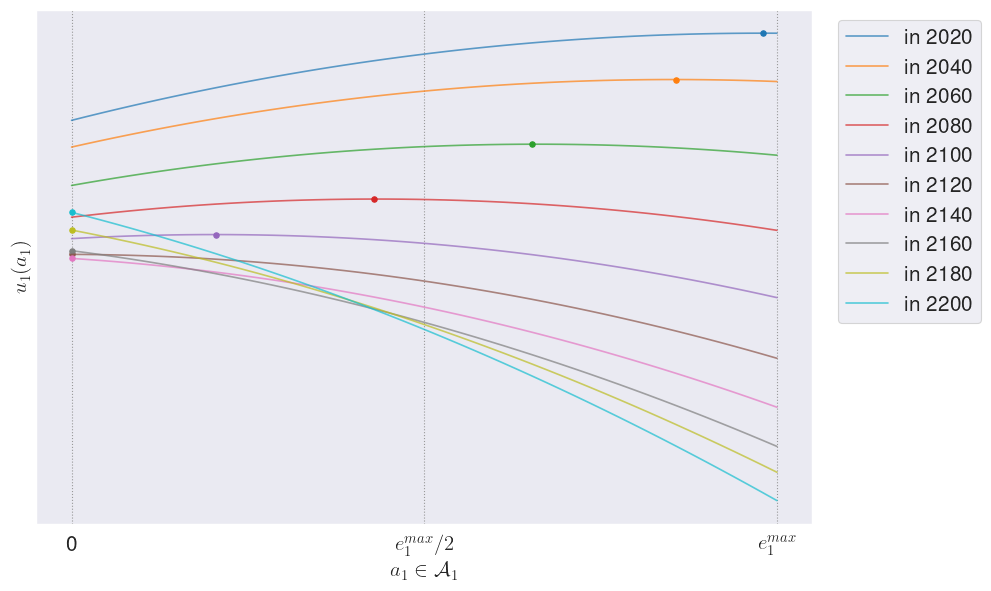

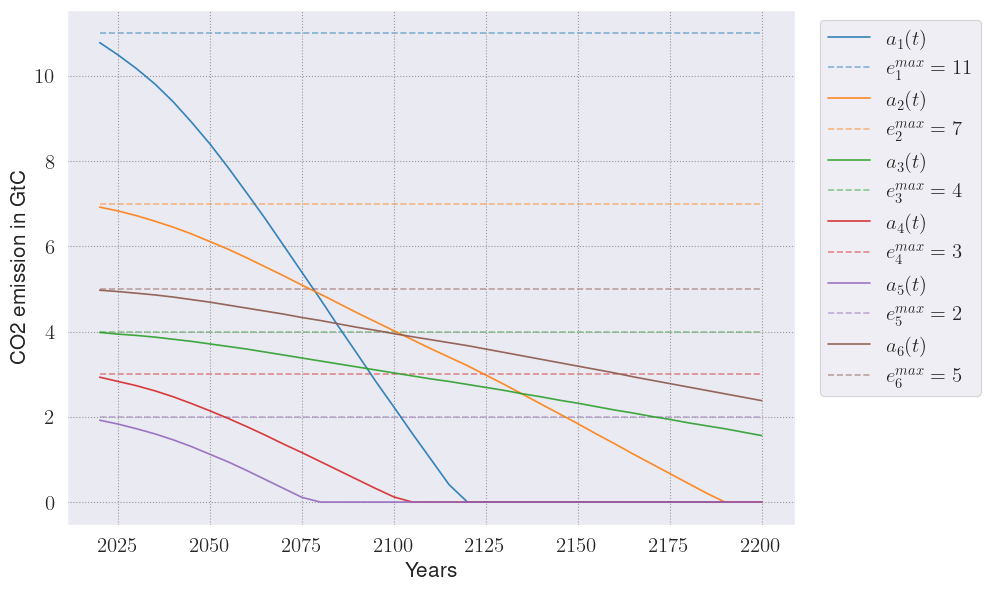

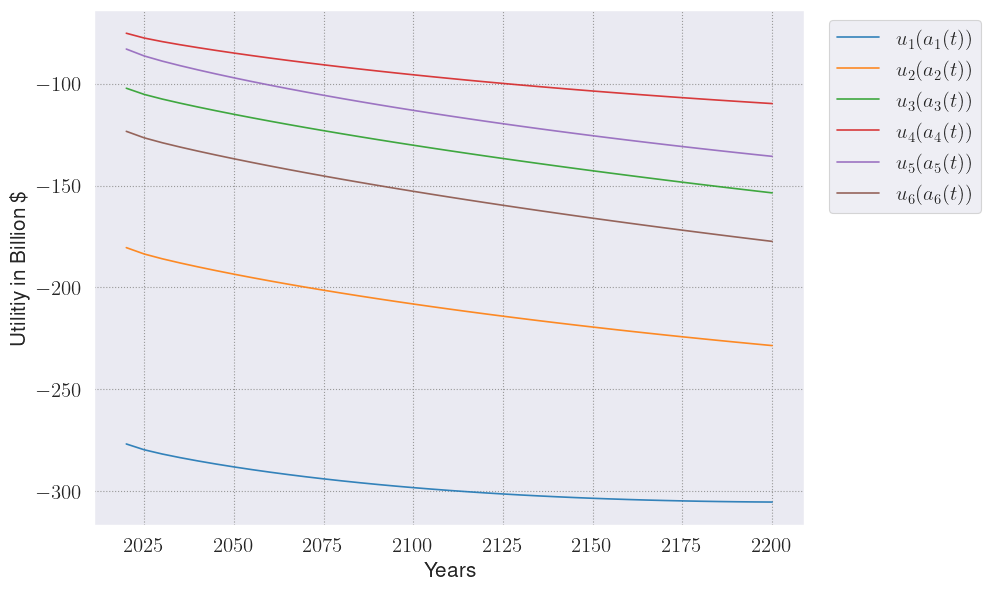

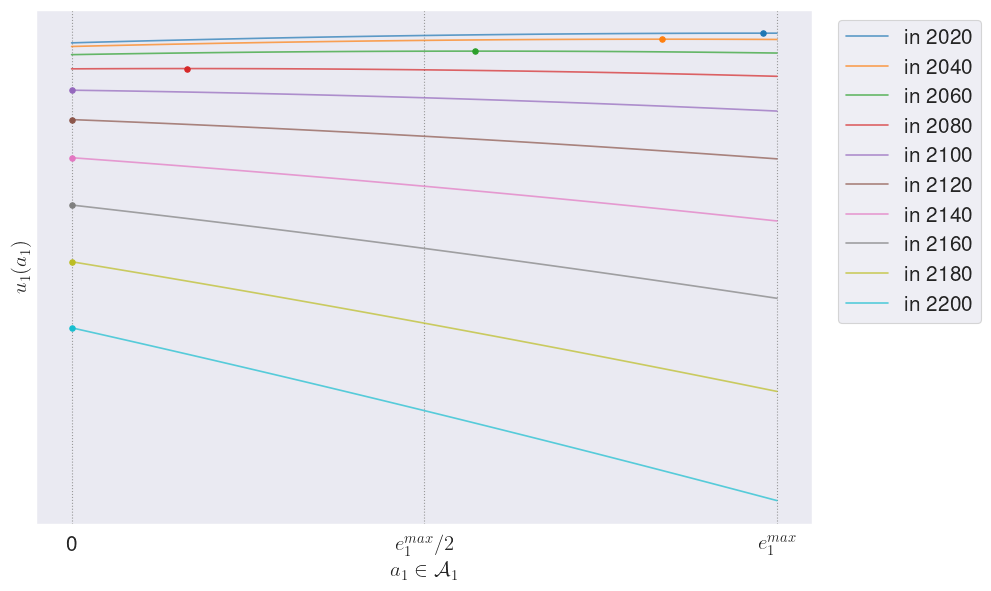

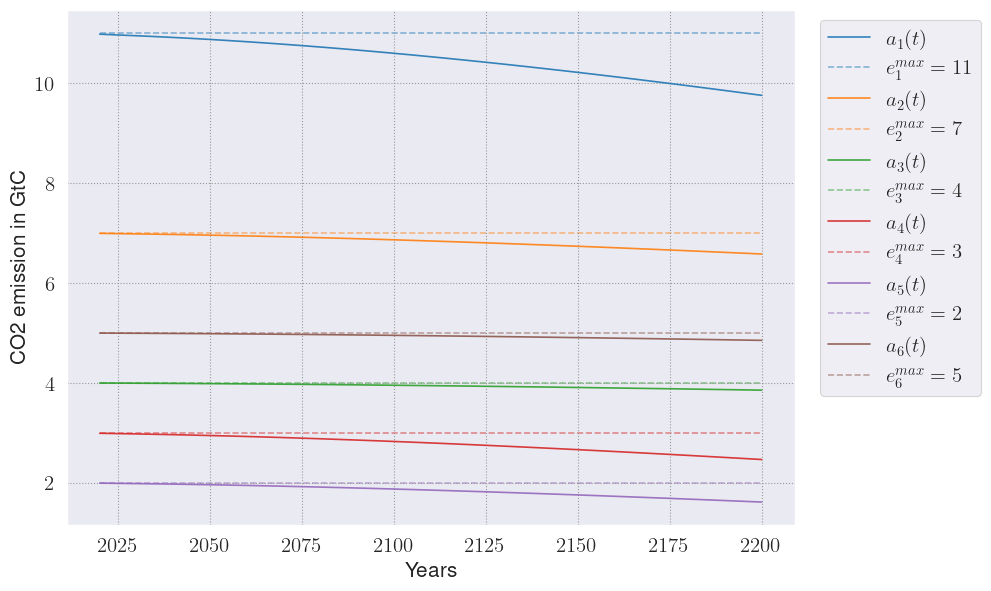

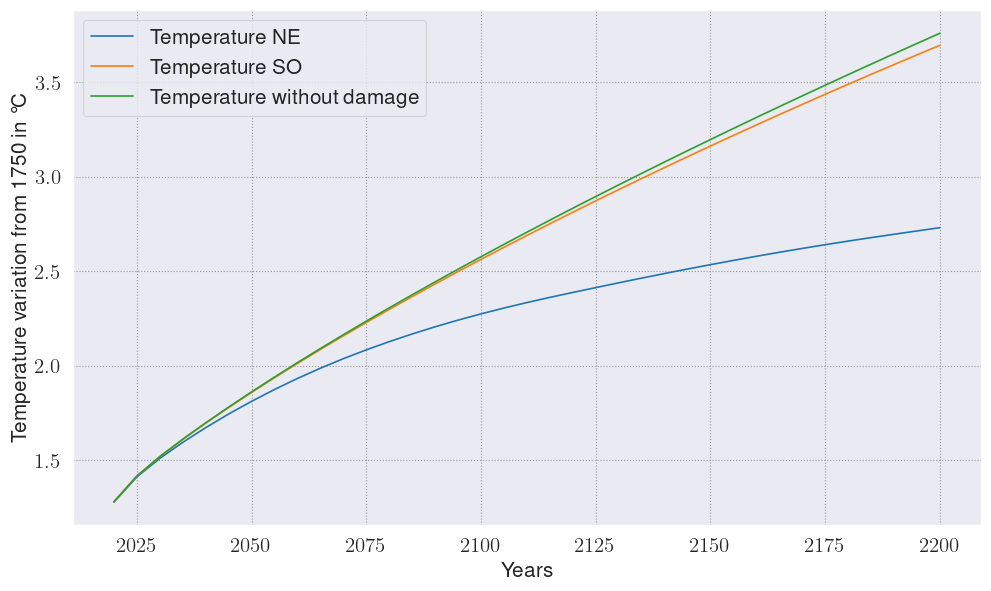

In [6]:
import scipy.stats as stats

alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/1000 
list_benef_coef = [np.array([0, beta_0[i] * 2 /action_sets[i][1] , - beta_0[i] / ( action_sets[i][1]**2)]) for i in range(N)]

damage_coef = np.array([0,-.45, .45]) # DICE damage function 


alpha = 2


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i], alpha=alpha, version='V2') for i in range(N)]

game = Game(deepcopy(smc), list_players, horizon=2200)



# game.repeated_s_o_one_shot_game()
# array_action, array_sum_action, list_temp = game.so_action_profiles, game.so_sum_action_profiles, game.so_temp_profile
list_temp_no_damage = np.array(list_temp_no_damage)
plot_Game(game, plot_nash=True, plot_SO=True,  figsize=(10,6), name='test_DICE_Damage',temp_no_damage=list_temp_no_damage)

In [23]:
list_benef_coef

[array([ 0.        ,  2.72727273, -0.12396694]),
 array([ 0.        ,  5.14285714, -0.36734694]),
 array([ 0.    ,  8.5   , -1.0625]),
 array([ 0.        ,  1.73333333, -0.28888889]),
 array([ 0. ,  1.6, -0.4]),
 array([ 0.  , 10.4 , -1.04])]

In [24]:
P = polynome([ 0.        ,  2.72727273, -0.12396694])


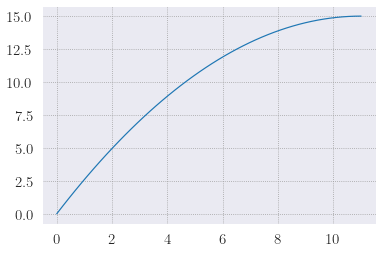

In [25]:
x = np.linspace(0,11)
plt.plot(x, P(x))

In [3]:
list_players

In [5]:
action = np.zeros(len(list_players))
for indice in range(len(list_players)):
    action[indice] = list_players[indice].action_set[1]
print(action)

[11.  7.  4.  3.  2.  5.]


In [7]:
action_space = np.zeros((len(list_players),2))
for indice in range(len(list_players)):
    action_space[indice,:] = list_players[indice].action_set

In [8]:
action_space

array([[ 0., 11.],
       [ 0.,  7.],
       [ 0.,  4.],
       [ 0.,  3.],
       [ 0.,  2.],
       [ 0.,  5.]])

In [9]:
action_space[:,1]

array([11.,  7.,  4.,  3.,  2.,  5.])